# Spider Plot

## get track results

download **images stacks** in green channel of each well from CellCyteX. Use imageJ, crop out cells near the wound area (cells near edge) and only calculate on the first 24 hours (frame 1-13).

Install plugin TrackMate, open it and start track for cell trajectory. Filter in this case used laplacian of Gaussian for edge detection and a LAP tracker to track cell trajectory. Gap and division are both allowed for the tracker.

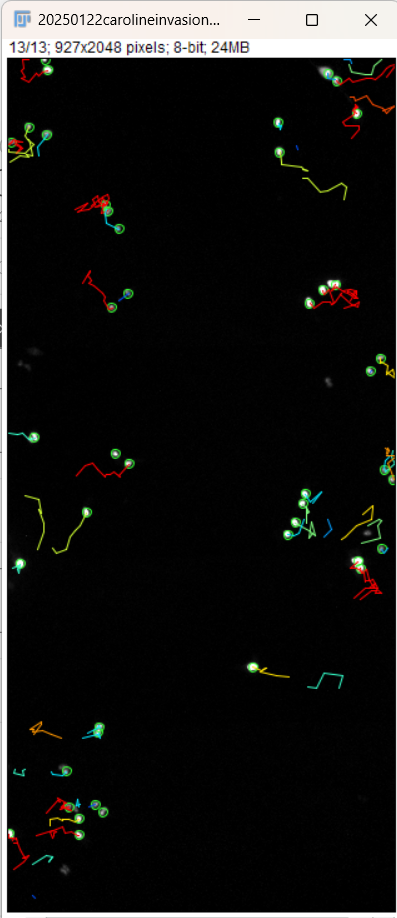

Export all track infomation to csv files, make sure all the track files are named as treatment_wellNumber

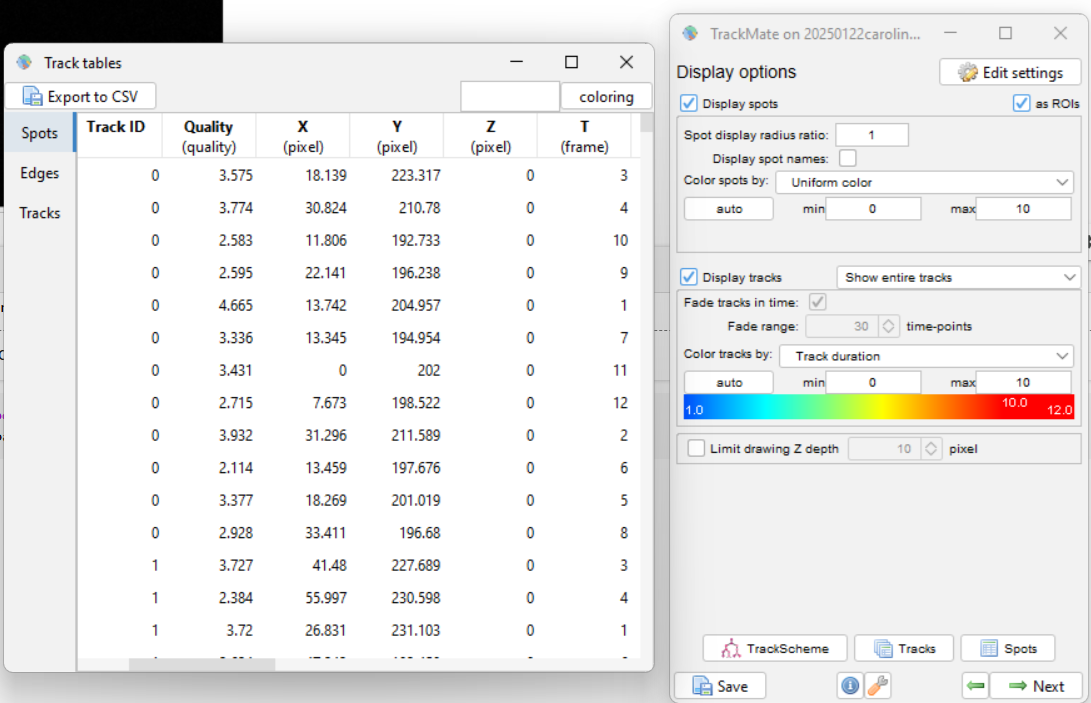

## run these cells only once

In [ ]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
def extract_position(df):

    # Ensure TRACK_ID is numeric
    df = df[pd.to_numeric(df['TRACK_ID'], errors='coerce').notna()].copy()

    df['TRACK_ID'] = df['TRACK_ID'].astype(int)
    df['FRAME'] = df['FRAME'].astype(int)
    df['POSITION_X'] = df['POSITION_X'].astype(float)
    df['POSITION_Y'] = df['POSITION_Y'].astype(float)

    #sort df first by track_ID, then by frame number
    df = df.sort_values(by=['TRACK_ID', 'FRAME'])

    # Group by TRACK_ID and collect positions
    grouped = df.groupby('TRACK_ID')[['POSITION_X', 'POSITION_Y']]
    position = grouped.apply(lambda g: g.values.tolist()).to_dict()
    position_index = list(position.keys())

    return position, position_index

In [ ]:
def set_start_point_with_frame_limit(position, position_index, frame):
    """
    Adjusts track positions relative to the first point and limits to frame length.
    """
    # Filter tracks that have at least 'frame' positions
    valid_tracks = {
        track_id: positions[:frame]
        for track_id, positions in position.items()
        if len(positions) >= frame
    }

    # Adjust positions relative to the first frame
    for track_id, points in valid_tracks.items():
        base_x, base_y = points[0]  # Set the first point as the reference
        valid_tracks[track_id] = [[(x - base_x) , (y - base_y) ] for x, y in points]

    return valid_tracks

In [ ]:
def spider_plot_well_stacked(repeats, frame, treatment):
    """
    Generates a stacked spider plot for cell movement across wells.
    """
    displacement = []

    plt.figure(figsize=(15, 8))

    for well_number in range(1, repeats + 1):
        if well_number not in dataframes:
            print(f"Warning: Well {well_number} not found in dataframes.")
            continue

        df = dataframes[well_number]
        position, position_index = extract_position(df)
        position_set = set_start_point_with_frame_limit(position, position_index, frame)

        for points in position_set.values():
            points_array = np.array(points[:frame])  # Plot up to 'frame' frames for consistency

            if len(points_array) > 0:  # Ensure it's not empty
                plt.plot(points_array[:, 0], points_array[:, 1])
                displacement.append(points_array[-1])  # Store last (x, y) position

    # Add plot formatting
    plt.axhline(y=0, color='black', linewidth=1)
    plt.axvline(x=0, color='black', linewidth=1)
    plt.xlim(-300, 300)
    plt.ylim(-150, 150)

    # Add title with treatment name
    plt.title(f"Spider Plot of {treatment} Movement")

    return displacement  # Return list of final positions


In [ ]:
displacement_treatments = {} # saved for part II

## run these for every treatment group

From here, upload all track CSV files from the **same** treatment group. And repeat the steps for each treatment group.



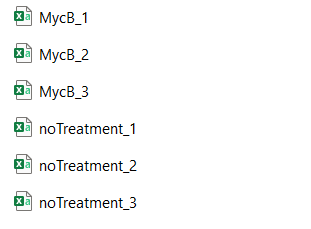

In [ ]:
upload = {}
uploaded = files.upload()  # Opens file picker for multiple files

Saving MycB_1.csv to MycB_1 (1).csv
Saving MycB_2.csv to MycB_2 (1).csv
Saving MycB_3.csv to MycB_3 (1).csv


In [ ]:
print(uploaded.keys()) # make sure uploaded files are correct

dict_keys(['MycB_1 (1).csv', 'MycB_2 (1).csv', 'MycB_3 (1).csv'])


In [ ]:
#No need to change this cell
dataframes = {}

for filename in uploaded.keys():
    print(f"Reading file: {filename}")
    df = pd.read_csv(io.BytesIO(uploaded[filename]))  # Read CSV
    labels = filename.split('_')
    well_number = labels[1][0]
    well_number = int(well_number)
    dataframes[well_number] = df

    # check for read results
    #print(df.head(5))

Reading file: MycB_1 (1).csv
Reading file: MycB_2 (1).csv
Reading file: MycB_3 (1).csv


**Don't forget to change treatment name in the cell**

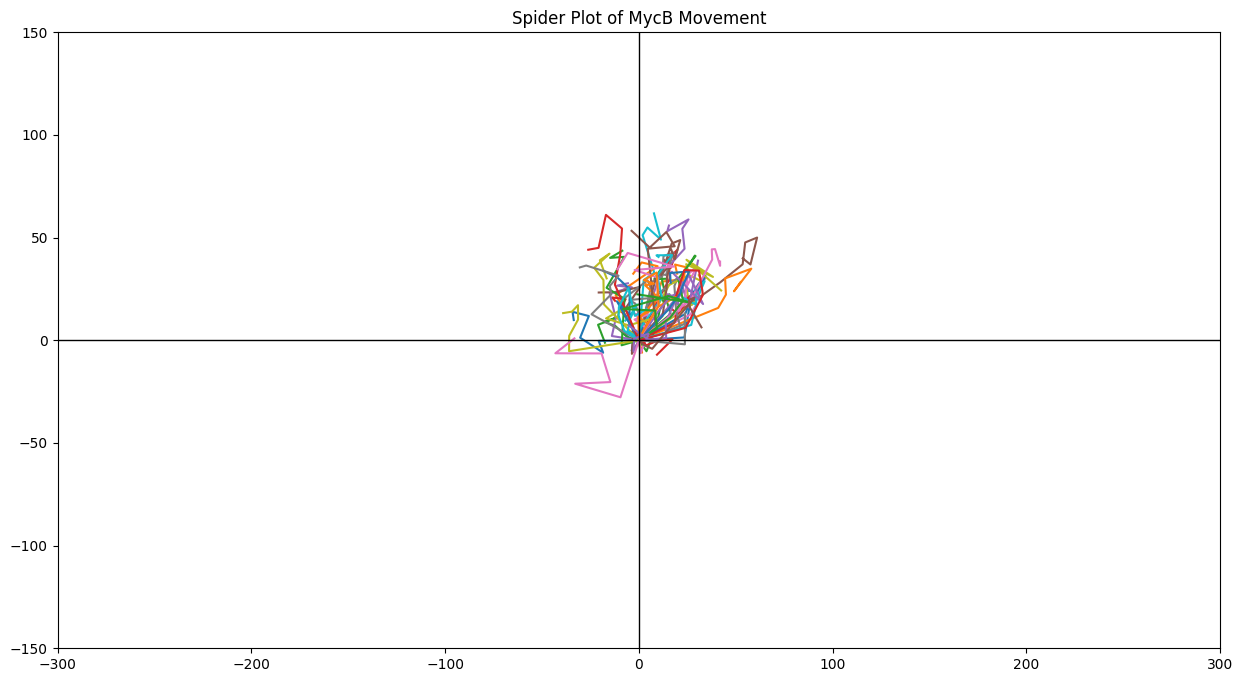

In [ ]:
treatment = 'MycB' #change treatment name everytime
repeats = 3 #depends on # of replicated for this treatment group
frame = 7 # depend on the duration of trajectory, set to (time(hours)/2) + 1

displacement_treatments[treatment] = spider_plot_well_stacked(repeats, frame, treatment)

# Displacement Analysis

using the final position of every trajectory

In [ ]:
print(displacement_treatments.keys()) #make sure all treatment groups are done

dict_keys(['MycB_50nM', 'Control', 'MycB'])


In [ ]:
results = []

for treatment, displacement in displacement_treatments.items():
    if not displacement:
      continue
    else:
      results[treatment] = []
      for item in displacement:
        results[treatment].append((item[0]**2 + item[1]**2)**0.5) #Eucledian distance, assuming the bottom of wells are completely flat


In [ ]:
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

def analyze_and_plot_displacement(results):

    # Convert dictionary to a DataFrame
    data = []
    for treatment, distances in results.items():
        for value in distances:
            data.append([treatment, value])

    df = pd.DataFrame(data, columns=["Treatment", "Displacement"])

    # box plot
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(x="Treatment", y="Displacement", data=df, palette="Set2")
    sns.swarmplot(x="Treatment", y="Displacement", data=df, color=".25", alpha=0.6)
    plt.xlabel("Treatment")
    plt.ylabel("Displacement (Final Distance)")
    plt.title("Comparison of Displacement Across Treatments")

    # significance test
    treatment_groups = [df[df["Treatment"] == treatment]["Displacement"].values for treatment in results.keys()]

    if len(treatment_groups) > 2:
        # ANOVA for multiple groups
        stat, p_value = stats.f_oneway(*treatment_groups)
        test_name = "ANOVA"

        # Perform Tukey HSD post-hoc test
        tukey = pairwise_tukeyhsd(df["Displacement"], df["Treatment"], alpha=0.05)
        print(tukey)

        # Add significance annotations to plot
        sig_pairs = []
        for i, (group1, group2) in enumerate(combinations(results.keys(), 2)):
            p = tukey.pvalues[i]
            if p < 0.05:  # Significance threshold
                sig_pairs.append((group1, group2, p))

    else:
        # t-test for two groups
        stat, p_value = stats.ttest_ind(*treatment_groups, equal_var=False)
        test_name = "t-test"

        #add p-value for two groups
        sig_pairs = [(*results.keys(), p_value)] if p_value < 0.05 else []

    print(f"{test_name} Statistic: {stat:.4f}, p-value: {p_value:.4e}")

    # add to plot
    def add_significance(ax, pairs, y_offset=5):

        max_y = df["Displacement"].max() + y_offset  # Start placing significance above the highest box
        for group1, group2, p in pairs:
            x1, x2 = list(results.keys()).index(group1), list(results.keys()).index(group2)
            y, h = max_y, 2  # Height increment
            max_y += y_offset  # Move up for next annotation
            plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color="black")
            plt.text((x1+x2)*0.5, y+h, f"p={p:.4f}", ha="center", va="bottom", fontsize=12, color="red")

    if sig_pairs:
        add_significance(ax, sig_pairs)

    plt.xticks(rotation=45)
    plt.show()

    return df

<ipython-input-75-50cd8039d7e1>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Treatment", y="Displacement", data=df, palette="Set2")


t-test Statistic: 8.4507, p-value: 3.7379e-14


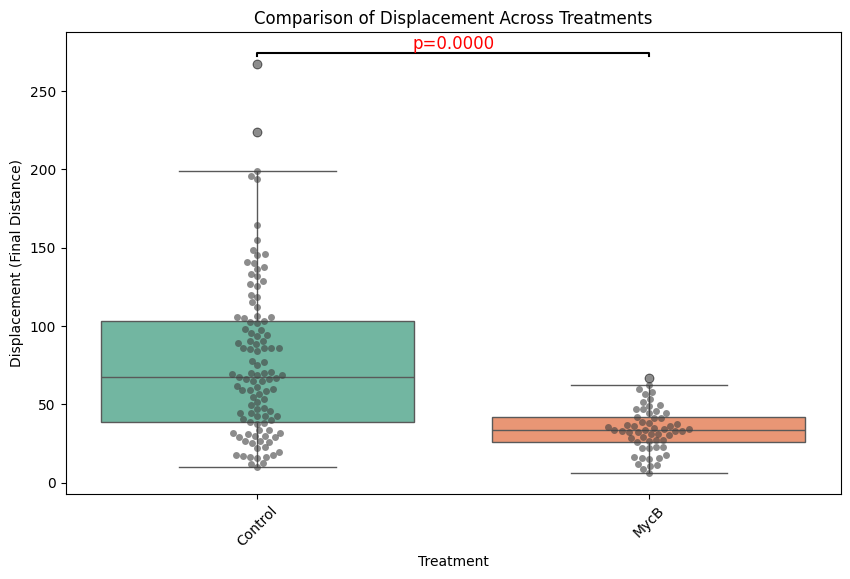

In [ ]:
df_results = analyze_and_plot_displacement(results)